## https://github.com/leongatys/PytorchNeuralStyleTransfer

In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


In [2]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [3]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = torchvision.models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [4]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/home/arg_ws3/.local/lib/python3.5/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [5]:
#get network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg =  VGGNet().to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [6]:
#load images, ordered as [style_image, content_image]
img_names = ['/home/arg_ws3/pytorch-tutorial/tutorials/03-advanced/neural_style_transfer/png/real.jpg', '/home/arg_ws3/pytorch-tutorial/tutorials/03-advanced/neural_style_transfer/png/unity.png']
imgs = [Image.open(name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)

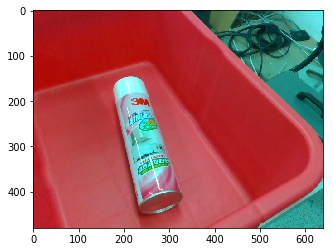

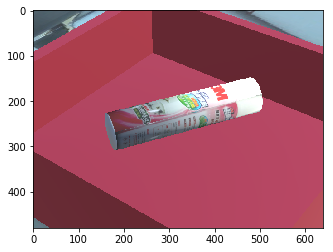

In [7]:
#display images
for img in imgs:
    imshow(img);show()

In [8]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
#style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
#content_targets = [A.detach() for A in vgg(content_image, content_layers)]
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image)]
content_targets = [A.detach() for A in vgg(content_image)]
targets = style_targets + content_targets

Iteration: 50, loss: 22718.222656
Iteration: 100, loss: 8035.909668
Iteration: 150, loss: 3274.957275
Iteration: 200, loss: 1498.143677
Iteration: 250, loss: 932.180481
Iteration: 300, loss: 676.401123
Iteration: 350, loss: 530.619080
Iteration: 400, loss: 425.431732
Iteration: 450, loss: 351.524353
Iteration: 500, loss: 297.707306


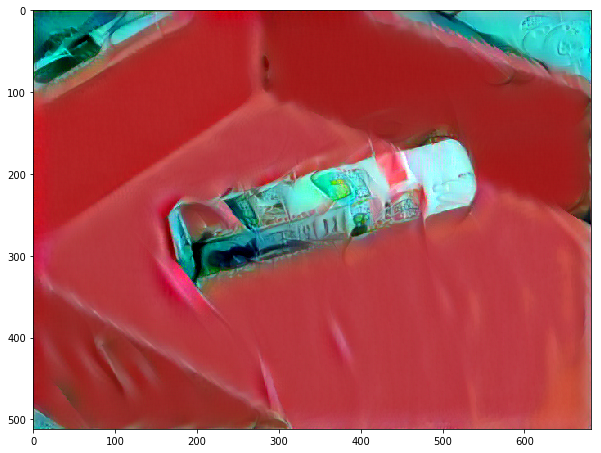

In [9]:
#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        #out = vgg(opt_img, loss_layers)
        out = vgg(opt_img)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [10]:
#"Controlling Perceptual Factors in Neural Style Transfer", Gatys et al. 
#(https://arxiv.org/abs/1611.07865)

#hr preprocessing
img_size_hr = 800 #works for 8GB GPU, make larger if you have 12GB or more
prep_hr = transforms.Compose([transforms.Scale(img_size_hr),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
#prep hr images
imgs_torch = [prep_hr(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

#now initialise with upsampled lowres result
opt_img = prep_hr(out_img).unsqueeze(0)
opt_img = Variable(opt_img.type_as(content_image.data), requires_grad=True)

#compute hr targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image)]
content_targets = [A.detach() for A in vgg(content_image)]
targets = style_targets + content_targets

Iteration: 50, loss: 670.177612
Iteration: 100, loss: 520.881470
Iteration: 150, loss: 134.713104
Iteration: 200, loss: 95.452126


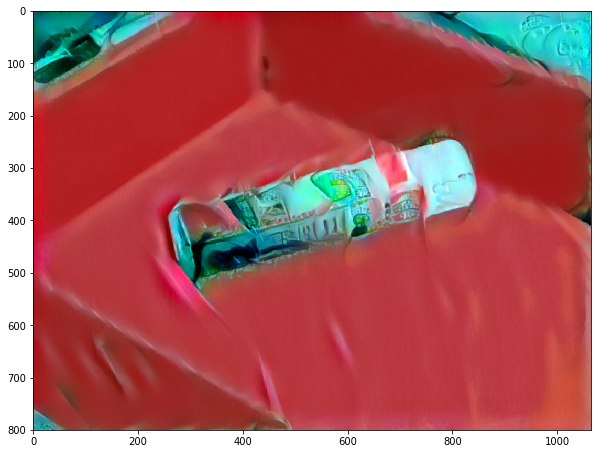

In [11]:
#run style transfer for high res 
max_iter_hr = 200
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]
while n_iter[0] <= max_iter_hr:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)
    
#display result
out_img_hr = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img_hr)
gcf().set_size_inches(10,10)